# Cloud Segmentation

Inspired by : How to Use Deep Learning, PyTorch Lightning, and the Planetary Computer to Predict Cloud Cover in Satellite Imagery (https://drivendata.co/blog/cloud-cover-benchmark/) \
Data Source : https://source.coop/repositories/radiantearth/cloud-cover-detection-challenge/ \
A complete access to DrivenData Cloud Cover Detection Challenge through Kaggle API : https://www.kaggle.com/datasets/hmendonca/cloud-cover-detection/data


In [25]:
import boto3
bucket_name = 'radiantearth'
online_folder='test_labels'  # 'test_features' 'test_labels' 'train_features'  #'train_labels' # 'train_features' 
state = 'private' #'public' # 'private'
prefix = f'cloud-cover-detection-challenge/final/{state}/{online_folder}'
local_dir = f'../data/cloud_data/final/{state}/{online_folder}'

# required to add to the environment variable : AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY
s3 = boto3.client('s3', endpoint_url='https://data.source.coop')
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
for obj in response.get('Contents', []):
    print(obj['Key'])

cloud-cover-detection-challenge/final/private/test_labels/aaaa.tif
cloud-cover-detection-challenge/final/private/test_labels/aaay.tif
cloud-cover-detection-challenge/final/private/test_labels/aabb.tif
cloud-cover-detection-challenge/final/private/test_labels/aabd.tif
cloud-cover-detection-challenge/final/private/test_labels/aabl.tif
cloud-cover-detection-challenge/final/private/test_labels/aaci.tif
cloud-cover-detection-challenge/final/private/test_labels/aacl.tif
cloud-cover-detection-challenge/final/private/test_labels/aacm.tif
cloud-cover-detection-challenge/final/private/test_labels/aaco.tif
cloud-cover-detection-challenge/final/private/test_labels/aacy.tif
cloud-cover-detection-challenge/final/private/test_labels/aaeg.tif
cloud-cover-detection-challenge/final/private/test_labels/aaen.tif
cloud-cover-detection-challenge/final/private/test_labels/aaha.tif
cloud-cover-detection-challenge/final/private/test_labels/aahh.tif
cloud-cover-detection-challenge/final/private/test_labels/aaii

In [ ]:
import os

# Ensure the local directory exists
os.makedirs(local_dir, exist_ok=True)

# List and download files
objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
for obj in objects.get('Contents', []):
    file_key = obj['Key']
    local_file_path = os.path.join(local_dir, os.path.relpath(file_key, prefix))
    
    # Create any necessary subdirectories
    os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
    
    # Download file
    s3.download_file(bucket_name, file_key, local_file_path)
    print(f"Downloaded {file_key} to {local_file_path}")

### Download the data using Kaggle API 

- run : pip install kaggle 
- Connect to kaggle API (username and API Key via Environmental variable) : export KAGGLE_USERNAME=... and export KAGGLE_KEY=...
- run : kaggle datasets download -d hmendonca/cloud-cover-detection (27GB)

## Load the data from S3 bucket 

Cloud data 
    final   
        private
            test_features
            test_labels
        public
            train_features
            train_labels
            train_metadata.csv


In [1]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import torch

In [2]:
DATA_DIR = Path.cwd().parent.resolve() / "data/cloud_drivendata/final/public"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

In [3]:
BANDS = ["B02", "B03", "B04", "B08"]

In [4]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [5]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        #assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        #assert df["label_path"].path.exists().all()

    return df

print(f"Feature directory : {TRAIN_FEATURES}")
print(f"Label directory : {TRAIN_LABELS}")
train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

Feature directory : /home/onyxia/work/damaged-building-detector/data/cloud_drivendata/final/public/train_features
Label directory : /home/onyxia/work/damaged-building-detector/data/cloud_drivendata/final/public/train_labels


,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...


In [6]:
len(train_meta)

11748

### Coordinates

In [7]:
# Convert the bounding box to longitude and latitude 
import pyproj
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

### True Color image

In [8]:
def load_channel_rasterio(filepath):
    """Load a single channel from a TIF file using rasterio."""
    with rasterio.open(filepath) as src:
        return src.read(1)

def load_channel_pil(filepath):
        return np.array(Image.open(filepath))

def true_color_img(chip_id, data_dir=TRAIN_FEATURES, load_channel_f=load_channel_pil):
        # Open image files as arrays, optionally including NIR channel

        chip_dir = data_dir / chip_id

        raw_rgb = np.stack([load_channel_f(chip_dir / "B04.tif"),
                            load_channel_f(chip_dir / "B03.tif"),
                            load_channel_f(chip_dir / "B02.tif"),
                           ], axis=-1)
    
        # Normalize pixel values 0-1 values
        return raw_rgb / raw_rgb.max()

In [9]:
import os 
def display_random_chip(metadata, data_dir=TRAIN_FEATURES):

    list_images = os.listdir(path=data_dir)
    random_chip_id = np.random.choice(list_images)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    random_chip = metadata[metadata["chip_id"]==random_chip_id].iloc[0]
    
    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = Image.open(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {random_chip.chip_id} label")

    plt.tight_layout()
    plt.show()

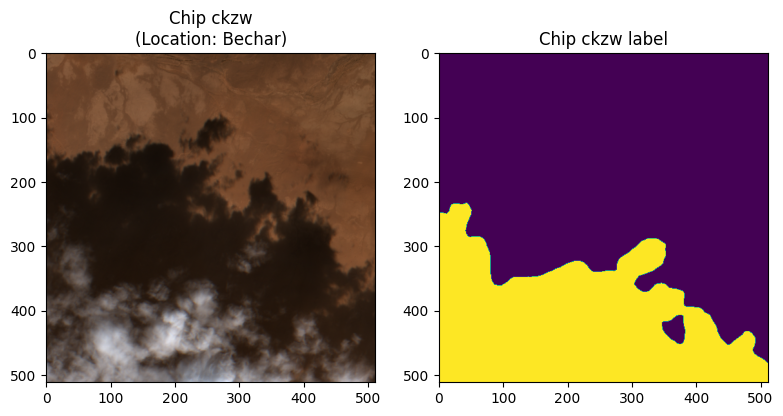

In [13]:
display_random_chip(train_meta)

### Split The Data

In [16]:
import random
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.2))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape

((2350, 9), (9398, 9))

In [17]:
train.head()

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...,/home/onyxia/work/damaged-building-detector/da...


In [18]:
# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

# Training 

In [19]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import numpy as np
from PIL import Image
import pandas as pd
from typing import List, Optional

class CloudDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        x_paths: pd.DataFrame,
        bands: List[str],
        y_paths: Optional[pd.DataFrame] = None,
        transform: Optional[A.Compose] = None,
        pytorch: bool = True
    ):
        super().__init__()
        self.data = x_paths
        self.label = y_paths
        self.bands = bands
        self.transform = transform
        self.pytorch = pytorch

    def __len__(self):
        return len(self.data)

    def load_channel_pil(self, filepath: str):
        return np.array(Image.open(filepath))

    def open_mask(self, filepath: str):
        mask = self.load_channel_pil(filepath)
        return mask  # mask is already 0-1 values

    def open_as_array(self, idx: int, invert=False):
        band_arrs = [self.load_channel_pil(self.data.loc[idx][f"{band}_path"]) for band in self.bands]
        x_arr = np.stack(band_arrs, axis=-1)
        if invert:
            x_arr = x_arr.transpose((2, 0, 1))
        # Normalize
        return (x_arr / np.iinfo(x_arr.dtype).max)

    def __getitem__(self, idx: int):
        x = self.open_as_array(idx, invert=self.pytorch)
        y = None 
        if self.label is not None:
            y = self.open_mask(self.label.iloc[idx]['label_path'])

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=x, mask=y) if y is not None else self.transform(image=x)
            x = augmented['image']
            y = augmented.get('mask', y)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.int64)

        return (x, y) if y is not None else x
    
    def __repr__(self):
        # Return a string representation of the dataset
        s = 'Dataset class with {} files'.format(self.__len__())
        return s


In [20]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from torchsummary import summary

# Vision-related imports
from torchvision.models import resnet18, resnet34

from datetime import datetime
import time


class ResNet_UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, pretrained=True, freeze_backbone = True):
        super().__init__()
        
        # Modify first layer of ResNet34 to accept custom number of channels
        base_model = resnet18(weights=pretrained)  # Change this line
        base_model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.base_layers = list(base_model.children())
        self.freeze_backbone(freeze_backbone)

        # Define the Unet Head/Neck
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        
        self.upconv4 = self.expand_block(512, 256)
        self.upconv3 = self.expand_block(256*2, 128)
        self.upconv2 = self.expand_block(128*2, 64)
        self.upconv1 = self.expand_block(64*2, 64)
        self.upconv0 = self.expand_block(64*2, out_channels)
        

    def forward(self, x):

        # Contracting Path
        layer0 = self.layer0(x)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        # Expansive Path
        upconv4 = self.upconv4(layer4)
        upconv3 = self.upconv3(torch.cat([upconv4, layer3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, layer2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, layer1], 1))
        upconv0 = self.upconv0(torch.cat([upconv1, layer0], 1))

        return upconv0

    def expand_block(self, in_channels, out_channels):
        expand = nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )
        return expand
    
    def freeze_backbone(self, freeze_backbone):
        if freeze_backbone:
            for l in self.base_layers:
                for param in l.parameters():
                    param.requires_grad = False


In [21]:
# Metrics 
class MeanPixelAccuracy:
    def __init__(self):
        pass

    def __call__(self, pred, target):
        # Calculate pixel-wise accuracy by comparing predicted and ground truth labels
        correct_pixels = (pred.argmax(dim=1) == target.to(pred.device)).float()
        mean_accuracy = correct_pixels.mean()
        return mean_accuracy

class IoUMetric:
    def __init__(self, smooth=1e-6):
        self.smooth = smooth  # Smooth term to prevent division by zero

    def __call__(self, pred, target):
        # pred shape: (batch_size, num_classes, height, width)
        # target shape: (batch_size, height, width)

        # Apply argmax to get predicted class per pixel
        pred = pred.argmax(dim=1)  # shape (batch_size, height, width)

        # Flatten predictions and target for calculation
        pred = pred.view(-1)       # shape (batch_size * height * width,)
        target = target.view(-1)   # shape (batch_size * height * width,)

        # Create a tensor to store IoU for each class
        num_classes = pred.max().item() + 1  # Determine the number of classes from pred
        ious = []

        for cls in range(num_classes):
            pred_cls = (pred == cls).float()  # 1 for pixels in the predicted class, else 0
            target_cls = (target == cls).float()  # 1 for pixels in the target class, else 0

            # Calculate intersection and union
            intersection = (pred_cls * target_cls).sum()
            union = pred_cls.sum() + target_cls.sum() - intersection

            # Compute IoU and add to the list
            iou = (intersection + self.smooth) / (union + self.smooth)
            ious.append(iou)

        # Calculate mean IoU over all classes
        mean_iou = torch.stack(ious).mean()
        
        return mean_iou


class DiceMetric:
    def __init__(self, smooth=1e-6):
        self.smooth = smooth  # Smooth term to prevent division by zero

    def __call__(self, pred, target):
        # pred shape: (batch_size, num_classes, height, width)
        # target shape: (batch_size, height, width)

        # Apply softmax to get probabilities for each class
        pred = pred.softmax(dim=1)  # shape (batch_size, num_classes, height, width)
        
        # Flatten predictions and target across spatial dimensions
        pred = pred.view(pred.size(0), pred.size(1), -1)  # (batch_size, num_classes, height * width)
        target = target.view(target.size(0), 1, -1)       # (batch_size, 1, height * width)

        # Create one-hot encoding for target
        target_one_hot = torch.zeros_like(pred).scatter_(1, target, 1)  # (batch_size, num_classes, height * width)

        # Calculate Dice score for each class
        intersection = (pred * target_one_hot).sum(dim=2)  # sum over pixels
        pred_sum = pred.sum(dim=2)
        target_sum = target_one_hot.sum(dim=2)

        # Compute Dice score for each class
        dice_score = (2 * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        
        # Average Dice score over classes
        mean_dice = dice_score.mean()
        
        return mean_dice

# Losses 
# Cross entropy loss : nn.CrossEntropyLoss()
# Dice Loss 
# IoU loss 

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth  # Smooth term to prevent division by zero

    def forward(self, pred, target):
        # pred shape (batch_size, num_classes, height, width)
        # target shape (batch_size, height, width)
        
        # Apply softmax to get probabilities for each class
        pred = pred.softmax(dim=1)  # shape (batch_size, num_classes, height, width)
        
        # Flatten predictions and target across spatial dimensions
        pred = pred.view(pred.size(0), pred.size(1), -1)  # shape (batch_size, num_classes, height * width)
        target = target.view(target.size(0), 1, -1)  # shape (batch_size, 1, height * width)

        # Create one-hot encoding for target
        target_one_hot = torch.zeros_like(pred).scatter_(1, target, 1)  # shape (batch_size, num_classes, height * width)

        # Calculate intersection and union
        intersection = (pred * target_one_hot).sum(dim=2)  # sum over pixels
        union = pred.sum(dim=2) + target_one_hot.sum(dim=2) - intersection  # sum over pixels
        
        # Compute IoU for each class and batch, add smooth for numerical stability
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        # Average IoU over classes and batch
        iou_loss = 1 - iou.mean()
        
        return iou_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth  # Smooth term to prevent division by zero

    def forward(self, pred, target):
        # pred shape (batch_size, num_classes, height, width), target shape (batch_size, height, width)
        # Apply softmax to pred if needed and flatten the tensors
        pred = pred.softmax(dim=1)  # ensure pred is a probability distribution per class
        
        # Convert to binary mask for Dice computation by treating each class separately
        # Flatten across pixels and batch
        pred = pred.view(pred.size(0), pred.size(1), -1)  # (batch_size, num_classes, height * width)
        target = target.view(target.size(0), 1, -1)      # (batch_size, 1, height * width)
        
        # Create a one-hot target vector (batch_size, num_classes, height * width)
        target_one_hot = torch.zeros_like(pred).scatter_(1, target, 1)

        # Calculate Dice coefficient for each class
        intersection = (pred * target_one_hot).sum(dim=2)
        pred_sum = pred.sum(dim=2)
        target_sum = target_one_hot.sum(dim=2)
        
        # Compute Dice loss
        dice_score = (2 * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        dice_loss = 1 - dice_score.mean()  # Mean over classes and batch
        
        return dice_loss

In [20]:
"""#### Test Losses and Metrics

images , yb = next(iter(train_dl))

model = ResNet_UNET()

pred = model(images)

### Test Metrics and Losses 
# xb , yb and pred
print("-----Losses-----")

cross_entropy_loss =  nn.CrossEntropyLoss(weight=torch.tensor([0.4,0.6]))
print(f'cross entropy loss {cross_entropy_loss(pred, yb)}')

dice_loss = DiceLoss()
print(f'dice loss : {dice_loss(pred=pred, target=yb)}')

iou_loss = IoULoss()
print(f'iou_loss : {iou_loss(pred=pred, target=yb)}')

print("-----Metrics----")
mean_pixel_acc = MeanPixelAccuracy()
print(f'mean_pixel_acc : {mean_pixel_acc(pred=pred,target=yb)}')

iou_metric = IoUMetric()
print(f'iou_metric : {iou_metric(pred=pred, target=yb)}')

dice_metric = DiceMetric()
print(f'dice_metric : {dice_metric(pred=pred, target=yb)}')"""

'#### Test Losses and Metrics\n\nimages , yb = next(iter(train_dl))\n\nmodel = ResNet_UNET()\n\npred = model(images)\n\n### Test Metrics and Losses \n# xb , yb and pred\nprint("-----Losses-----")\n\ncross_entropy_loss =  nn.CrossEntropyLoss(weight=torch.tensor([0.4,0.6]))\nprint(f\'cross entropy loss {cross_entropy_loss(pred, yb)}\')\n\ndice_loss = DiceLoss()\nprint(f\'dice loss : {dice_loss(pred=pred, target=yb)}\')\n\niou_loss = IoULoss()\nprint(f\'iou_loss : {iou_loss(pred=pred, target=yb)}\')\n\nprint("-----Metrics----")\nmean_pixel_acc = MeanPixelAccuracy()\nprint(f\'mean_pixel_acc : {mean_pixel_acc(pred=pred,target=yb)}\')\n\niou_metric = IoUMetric()\nprint(f\'iou_metric : {iou_metric(pred=pred, target=yb)}\')\n\ndice_metric = DiceMetric()\nprint(f\'dice_metric : {dice_metric(pred=pred, target=yb)}\')'

In [23]:
def validate(model: nn.Module, dataloader: DataLoader, 
             loss_fns: List[nn.Module], loss_weights: torch.tensor, 
             metric_fns: List[object], device: str, writer: SummaryWriter, epoch: int):

    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_metrics = {metric.__class__.__name__: 0.0 for metric in metric_fns}
    dict_losses = {loss_fn.__class__.__name__: [] for loss_fn in loss_fns}  # Dictionary to store individual losses

    with torch.no_grad():
        for step, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            total_loss = 0  # Reset loss for each batch
            outputs = model(x)

            # Assuming outputs and y are on the GPU
            loss_vals = torch.stack([loss_fn(outputs, y) for loss_fn in loss_fns], dim=0)  # Stack losses
            total_loss = loss_weights@loss_vals   

            # Update individual losses if needed for tracking
            for i, loss_fn in enumerate(loss_fns):
                dict_losses[loss_fn.__class__.__name__].append(loss_vals[i].item())         

            # Calculate Metrics
            for metric_fn in metric_fns:
                metric_res = metric_fn(pred=outputs, target=y)
                running_metrics[metric_fn.__class__.__name__] += metric_res.item() * dataloader.batch_size

            running_loss += total_loss.item() * dataloader.batch_size

            # Log individual loss to TensorBoard every 10 steps
            if step % 50 == 0:
                for loss_name, loss_values in dict_losses.items():
                    writer.add_scalar(f'valid/{loss_name}_loss', loss_values[-1], epoch * len(dataloader) + step)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    for metric_name in running_metrics:
        running_metrics[metric_name] /= len(dataloader.dataset)

    return epoch_loss, running_metrics


In [24]:
import torch
import os
import time
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.amp import autocast, GradScaler

def train(model, train_dl, valid_dl, loss_fns, loss_weights:torch.tensor=None, optimizer=None,
          scheduler=None, metric_fns=None, epochs=1, experiment_name="experiment",
          log_dir="runs", verbose=False, device="cuda", model_dir="models", scaler=None):

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(log_dir, f"{experiment_name}_{timestamp}")
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir)

    os.makedirs(model_dir, exist_ok=True)

    if loss_weights is None:
        loss_weights = torch.tensor([1.0 / len(loss_fns)] * len(loss_fns), device=device)
    elif torch.abs(torch.sum(loss_weights) - 1) > 1e-6:
        raise ValueError("The loss weights must sum to 1!")

    model.to(device) #send the model to device
    best_loss = float('inf')
    train_loss, valid_loss = [], []
    dict_losses = {loss_fn.__class__.__name__: [] for loss_fn in loss_fns}
    overall_metrics = {metric.__class__.__name__: [] for metric in metric_fns or []}

    start = time.time()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}\n{"-" * 10}')
        model.train()
        running_loss = 0.0

        for step, (x, y) in enumerate(train_dl):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast("cuda"):
                outputs = model(x)
                # Assuming outputs and y are on the GPU
                loss_vals = torch.stack([loss_fn(outputs, y) for loss_fn in loss_fns], dim=0)  # Stack losses
                # Compute total weighted loss as a single operation
                total_loss = loss_weights@loss_vals

            # Update individual losses if needed for tracking
            for i, loss_fn in enumerate(loss_fns):
                dict_losses[loss_fn.__class__.__name__].append(loss_vals[i].item())

            # Use scaler to scale the loss before backward
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += total_loss.item() * train_dl.batch_size

            # Log individual loss to TensorBoard every few steps
            if step % 50 == 0:
                for loss_name, loss_values in dict_losses.items():
                    writer.add_scalar(f'train/{loss_name}_loss', loss_values[-1], epoch * len(train_dl) + step)
                writer.add_scalar(f'train/loss', total_loss.item(), epoch * len(train_dl) + step)

        epoch_train_loss = running_loss / len(train_dl.dataset)
        train_loss.append(epoch_train_loss)

        # Validation
        val_epoch_loss, val_metrics = validate(model, valid_dl, loss_fns, loss_weights, metric_fns, device, writer, epoch)
        valid_loss.append(val_epoch_loss)

        # Print epoch summary
        print(f'Train Loss: {epoch_train_loss:.4f}')
        print(f'Valid Loss: {val_epoch_loss:.4f}')

        writer.add_scalar('valid/loss', val_epoch_loss, epoch) #composite validation loss
        for metric_name, metric_value in val_metrics.items():
            writer.add_scalar(f'valid/{metric_name}', metric_value, epoch)

        if val_epoch_loss < best_loss:
            print("Updating best model")
            best_loss = val_epoch_loss
            torch.save(model.state_dict(), os.path.join(model_dir, f"{experiment_name}_best_model.pth"))

        for metric_name, metric_value in val_metrics.items():
            overall_metrics[metric_name].append(metric_value)

        if scheduler:
            scheduler.step()

    writer.close()
    print(f'Training complete in {(time.time() - start) // 60}m')
    return train_loss, valid_loss, overall_metrics


In [25]:
# Example of augmentation pipeline
def get_segmentation_augmentation():
    return A.Compose([
        #Resizing 
        A.Resize(height=512, width=512),
        # Spatial-level augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5, border_mode=0),
        
        # Color augmentations
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),

        # Additional augmentations for robustness
        #A.GaussianBlur(blur_limit=3, p=0.3),
        #A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        
        # Ensure final transformation to tensors
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ], is_check_shapes=False)


In [26]:
train_ds = CloudDataset(
            x_paths=train_x,
            bands=["B04", "B03", "B02"],
            y_paths=train_y,
            transform=None
        )
valid_ds = CloudDataset(
            x_paths=val_x,
            bands=["B04", "B03", "B02"],
            y_paths=val_y,
            transform=None
        )

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=16, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=16, pin_memory=True)

In [27]:
from torch.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will be trained on {device}")

model = ResNet_UNET(3, 2, pretrained=True, freeze_backbone=True)

loss_fns = [DiceLoss(), nn.CrossEntropyLoss()]
loss_weights = torch.tensor([0.4, 0.6], device=device)
metric_fns = [IoUMetric(), MeanPixelAccuracy(), DiceMetric()]
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 


# optimization features 
torch.backends.cudnn.benchmark = True
scaler = GradScaler()

# Train the model
train_loss, valid_loss, overall_metrics = train(
    model, 
    train_dl,
    valid_dl, 
    loss_fns=loss_fns,
    loss_weights=loss_weights,
    optimizer=optimizer_ft, 
    metric_fns=metric_fns,
    log_dir="../runs",
    experiment_name='ResNet_Unet_DrivenData',
    epochs=100,
    device=device,
    verbose=True,
    model_dir="../models",
    scaler=scaler
    )

Model will be trained on cuda


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/onyxia/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


Epoch 1/100
----------
Train Loss: 0.5959
Valid Loss: 0.5701
Updating best model
Epoch 2/100
----------
Train Loss: 0.5594
Valid Loss: 0.5655
Updating best model
Epoch 3/100
----------
Train Loss: 0.5497
Valid Loss: 0.5607
Updating best model
Epoch 4/100
----------
Train Loss: 0.5437
Valid Loss: 0.5657
Epoch 5/100
----------
Train Loss: 0.5379
Valid Loss: 0.5533
Updating best model
Epoch 6/100
----------
Train Loss: 0.5336
Valid Loss: 0.5567
Epoch 7/100
----------
Train Loss: 0.5305
Valid Loss: 0.5321
Updating best model
Epoch 8/100
----------
Train Loss: 0.5261
Valid Loss: 0.5314
Updating best model
Epoch 9/100
----------
Train Loss: 0.5229
Valid Loss: 0.5329
Epoch 10/100
----------
Train Loss: 0.5192
Valid Loss: 0.5477
Epoch 11/100
----------
Train Loss: 0.5149
Valid Loss: 0.5219
Updating best model
Epoch 12/100
----------
Train Loss: 0.5120
Valid Loss: 0.5198
Updating best model
Epoch 13/100
----------
Train Loss: 0.5089
Valid Loss: 0.5147
Updating best model
Epoch 14/100
----------

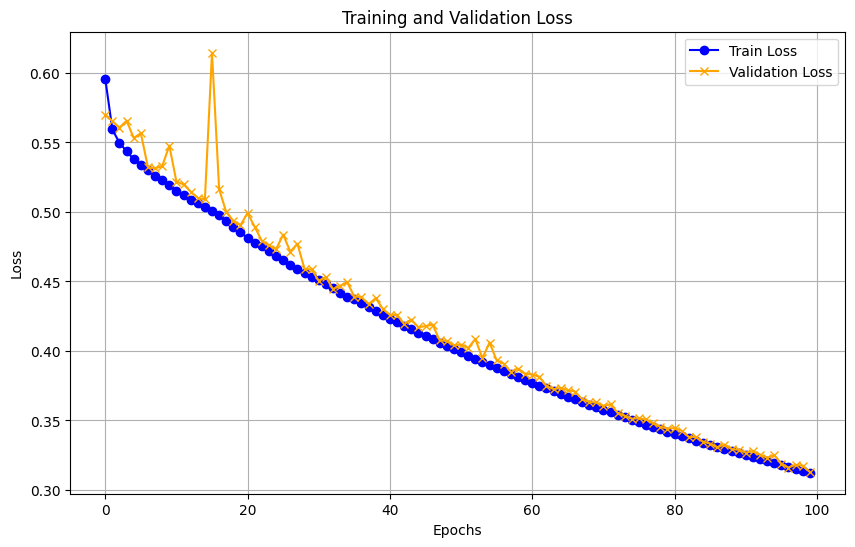

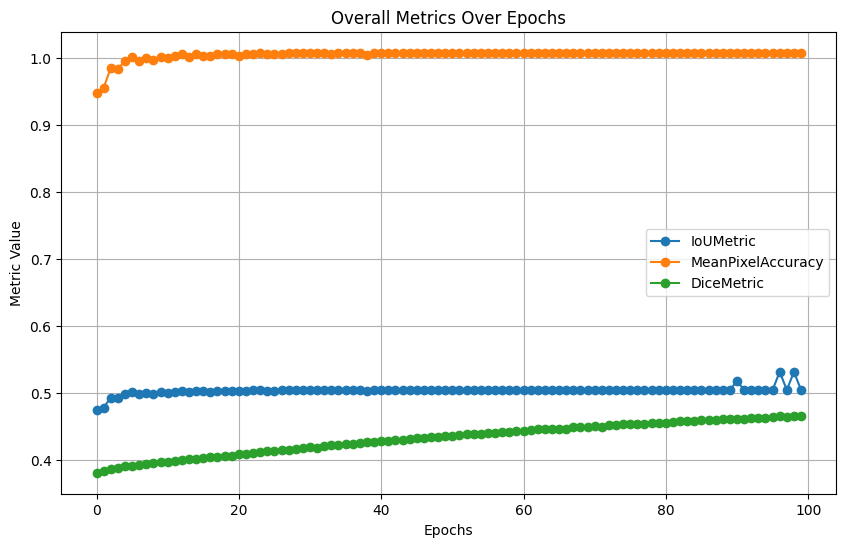

In [28]:
import matplotlib.pyplot as plt 

def plot_losses(train_loss: list, valid_loss: list, overall_metrics: dict):
    """
    Plots the training and validation losses and the metrics.

    Args:
    - train_loss (list): List of training loss values.
    - valid_loss (list): List of validation loss values.
    - overall_metrics (dict): Dictionary containing metric names and their values.

    Returns:
    - None
    """
    # Convert lists to PyTorch tensors
    train_loss_tensor = torch.tensor(train_loss)
    valid_loss_tensor = torch.tensor(valid_loss)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_tensor.cpu().numpy(), label='Train Loss', color='blue', marker='o')
    plt.plot(valid_loss_tensor.cpu().numpy(), label='Validation Loss', color='orange', marker='x')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()

    # Plot Overall Metrics
    plt.figure(figsize=(10, 6))
    for metric_name, values in overall_metrics.items():
        plt.plot(list(range(len(values))), values, label=metric_name, marker='o')

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Overall Metrics Over Epochs')
    plt.grid(True)
    plt.show()


# Assuming train_loss, valid_loss, and overall_metrics are defined somewhere in your code
plot_losses(train_loss, valid_loss, overall_metrics)

In [29]:
!mc cp /home/onyxia/work/damaged-building-detector/models/ResNet_Unet_DrivenData_best_model.pth s3/mbesnier/diffusion/damage_detection/cloud-segmentation-data/models/

..._model.pth: 53.45 MiB / 53.45 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 116.08 MiB/s 0s